## Low Noise Neural Network

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import pprint as pp
import random
import time
import sys
import os
try:
   import cPickle as cPickle
except:
   import pickle as cPickle

### Load Data

In [2]:
data = pd.read_csv('dataset/processed_pos_neg_reviews.csv', encoding='latin-1')

In [3]:
data.head()

,ProductId,Rating,Summary,Text,Label
0,B004779XNW,5,Best K cup Coffee,I like almost all of the Green Mountain coffee...,POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B000JGLE0U,4,yummy cakes,These cakes were really good and small enough ...,POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B001VJ0B0I,5,Read before you buy,"First of all, it lists the ingredients right h...",POSITIVE


In [4]:
data.Label.value_counts()

POSITIVE    82037
NEGATIVE    82037
Name: Label, dtype: int64

### Data Preparation

Training Data

In [5]:
# first 70000 reviews
training_data = data[0:70000].reset_index(drop=True)
training_data_length = training_data.shape[0]
training_data.head()

,ProductId,Rating,Summary,Text,Label
0,B004779XNW,5,Best K cup Coffee,I like almost all of the Green Mountain coffee...,POSITIVE
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NEGATIVE
2,B000JGLE0U,4,yummy cakes,These cakes were really good and small enough ...,POSITIVE
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,NEGATIVE
4,B001VJ0B0I,5,Read before you buy,"First of all, it lists the ingredients right h...",POSITIVE


Shape of training data

In [6]:
pp.pprint(training_data.shape)
pp.pprint(training_data.Label.shape)

(70000, 5)
(70000,)


Validation Data

In [7]:
# middle 6019 reviews
validation_data = data[70000:76019].reset_index(drop=True)
validation_data_length = validation_data.shape[0]
validation_data.head()

,ProductId,Rating,Summary,Text,Label
0,B001LGGH40,4,"Refreshing, but a tad too sweet",Nice refreshing beverage but with 120 cal a bi...,POSITIVE
1,B001VJ0B0I,2,"Gross by-products, sugar, and food colorings--...",I completely agree that the ingredients for th...,NEGATIVE
2,B004U7QQFC,5,My favorite coffeee,Just goes to show everyone has different taste...,POSITIVE
3,B001VJ0B0I,2,Read the Ingredient List,Make sure you read the list of ingredients bef...,NEGATIVE
4,B000EFHST2,5,Yummy!,The fastest and easiest Hamburger Helper I've ...,POSITIVE


Shape of validation data

In [8]:
pp.pprint(validation_data.shape)
pp.pprint(validation_data.Label.shape)

(6019, 5)
(6019,)


Testing Data

In [9]:
# last 6018 reviews
test_data = data[76019:82037].reset_index(drop=True)
test_data_length = test_data.shape[0]
test_data.head()

,ProductId,Rating,Summary,Text,Label
0,B003NV2IG2,2,Inconsistent Taste,I first tasted Annie Chun's seaweed three year...,NEGATIVE
1,B000ODH4BG,5,"Not meant to be a meal, but a terrific filler",This soup is great tasting. It does contain q...,POSITIVE
2,B003NV2IG2,2,"Nothing like sushi, that's for sure","For me, these were a total bust. The texture s...",NEGATIVE
3,B005GIF5VU,4,The only treats my cat will eat,So my Mom often buys bags of kitty treats for ...,POSITIVE
4,B003NV2IG2,2,Mediocre for Seaweed Snacking,This is one of many varieties of seaweed snack...,NEGATIVE


Shape of testing data

In [10]:
pp.pprint(test_data.shape)
pp.pprint(test_data.Label.shape)

(6018, 5)
(6018,)


#### Theory Validation

In [11]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()
positive_negative_ratios = Counter()

In [12]:
for i in range(training_data.shape[0]):
    if(training_data.Label[i] == "NEGATIVE"):
        for word in training_data.Text[i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1
    if(training_data.Label[i] == "POSITIVE"):
        for word in training_data.Text[i].split(" "):
            positive_counts[word] += 1
            total_counts[word] += 1

 Most common words in positive reviews.

In [13]:
# print first 10 most common words in positive reviews
pp.pprint(positive_counts.most_common()[0:10])

[('the', 96066),
 ('I', 82968),
 ('and', 75834),
 ('a', 71682),
 ('', 59808),
 ('to', 59166),
 ('of', 47005),
 ('is', 44519),
 ('it', 38075),
 ('for', 32320)]


 Most common words in negative reviews.

In [14]:
# print first 10 words common in negative reviews
pp.pprint(negative_counts.most_common()[0:10])

[('the', 124045),
 ('I', 102419),
 ('and', 75135),
 ('a', 69160),
 ('to', 68884),
 ('', 65592),
 ('of', 57132),
 ('it', 44415),
 ('is', 41260),
 ('this', 37592)]


It seems like words like **the**, **I** and **and** are some of the most frequent words in my dataset. However, they are **non-sentimental** words, hence are just noise. The frequency of a word is not a good indicator of the sentiment in a sentence, hence will have to come up with a better approach.

A good approach would be to find the ratio of these words for both positive and negative reviews

### Ratio of Frequency of a Word in Positive Reviews / Frequency of a Word in Negative Reviews

In [15]:
for word,count in list(total_counts.most_common()):
    if(count > 100):
        positive_negative_ratio = float(positive_counts[word]) / float(negative_counts[word]+1)
        positive_negative_ratios[word] = positive_negative_ratio

for word,ratio in positive_negative_ratios.most_common():
    if(ratio > 1):
        positive_negative_ratios[word] = np.log(ratio)
    else:
        positive_negative_ratios[word] = -np.log((1/(ratio+0.001)))

Words most frequently seen in a review with a "POSITIVE" label

In [16]:
# first 10 words
pp.pprint(positive_negative_ratios.most_common()[0:10])

[('/>Highly', 4.6347289882296359),
 ('delicious!', 2.8371272433773522),
 ('Highly', 2.7273080177066245),
 ('Perfect', 2.7146947438208788),
 ('Excellent', 2.544498746990246),
 ('downside', 2.4541349911212467),
 ('amazing!', 2.2617630984737906),
 ('pleasantly', 2.2407096892759584),
 ('Great', 2.0373300563297092),
 ('beats', 2.0188169198634012)]


Words most frequently seen in a review with a "NEGATIVE" label

In [17]:
# first 10 words
pp.pprint(list(reversed(positive_negative_ratios.most_common()))[0:10])

[('NO<br', -6.9077552789821368),
 ('desk,', -4.299259050687561),
 ('deliberately', -3.9595188268977228),
 ('menadione', -3.5209466347720815),
 ('intentionally', -3.4833958767229474),
 ('garbage.', -3.4342372357403557),
 ('refund.', -3.25557390095137),
 ('nasty.', -3.2448429835246579),
 ('ripping', -3.2038896704313373),
 ('banned', -3.0692809615768031)]


### Signal to Noise Ratio (S/N)

Most of the words that contribute to the weights of our neural network are really neutral words that have no meaning to the whether a text is spam or not. For example most common words like `., !, !!, ?, the, and, to, this, that`. Because of that, it would really increase the efficiency of our network by eliminating their contribution. 

#### Transform Text into Numbers Using the Bag-of-Words Technique

In [18]:
vocab = set(total_counts.keys())
vocab_size = len(vocab)

Create the bag-of-words vocabulary vector

In [19]:
vocab_vector_column = np.zeros((1, vocab_size))

All columns initialised to zero

In [20]:
pp.pprint(vocab_vector_column)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])


Size of our bag-of-words -which should be one row and as many columns as the no. of unique words.

In [21]:
pp.pprint(vocab_vector_column.shape)

(1, 182360)


Now, let's create a dictionary that allows us to look at every word in our vocabulary and map it to the `vocab_vector_column`.

In [22]:
#  Maps a word to its column in the vocab_vector
word_column_dict = {}

for i, word in enumerate(vocab):
    # {key: value} is {word: column}
    word_column_dict[word] = i

Example:

**word_column_dict**
```python
{"horrible" : 12345, "disgusting" : 3, "defaced" : 182925 ....}
```

**vocab_vector_column**
```python
vocab_vector_column[0][12345]
```

In [23]:
vocab_vector_column[0][word_column_dict["horrible"]]

0.0

#### Use function below to show count of various start words

In [24]:
def slice_dict(dict, pattern):
    return {k:v for k,v in dict.items() if k.startswith(pattern)}

For instance the exclamation mark(!), full-stop(.), spaces( ), question mark(?) e.t.c. From this we can be able to clearly see that there is a lot of noise in our dataset. We need to clean it up.

In [25]:
pp.pprint(slice_dict(word_column_dict, "!"))

{'!': 76462,
 '!!': 95268,
 '!!!': 120087,
 '!!!!': 172753,
 '!!!!!': 41027,
 '!!!!!!': 129813,
 '!!!!!!!': 12085,
 '!!!!!!!!': 15775,
 '!!!!!!!!!': 32604,
 '!!!!!!!!!!!': 9664,
 '!!!!!!!!!!!!!!!': 79351,
 '!!!!!!!!!!!!!!!!!!!!!!!': 90974,
 '!!!!!!!!!!!<br': 53056,
 '!!!!!!!!!!<br': 9963,
 '!!!!!!!....': 18591,
 '!!!!!!!<br': 163774,
 '!!!!!!<br': 103401,
 '!!!!!<br': 15872,
 '!!!!!IMPORTANT': 160868,
 '!!!!<br': 1032,
 '!!!),': 37843,
 '!!!---style...mellow': 100913,
 '!!!.': 149982,
 '!!!..': 44657,
 '!!!<a': 14349,
 '!!!<br': 92001,
 '!!!THIS': 83827,
 '!!!The': 125029,
 '!!!aweful': 83018,
 '!!)': 28835,
 '!!).': 178148,
 '!!<br': 139396,
 '!!BUT!!': 73569,
 '!!IN': 115633,
 '!!Pretty': 139689,
 '!"': 61795,
 '!#@*#!': 107889,
 '!)': 38555,
 '!..': 96756,
 '!...UPDATE...': 172215,
 '!<br': 93844,
 '!?': 86001,
 '!?!?!?!<br': 28598,
 '!@#%': 123084,
 '!Keep': 129327,
 '!Maybe': 165672,
 '!Nothing': 116340,
 '!She': 75859,
 '!Very': 22829}


In [26]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

Look at the distribution below, where these words (the middle of our distribution) are just noise being added to our network, and in the process reducing the efficiency. 

In [27]:
hist, edges = np.histogram(list(map(lambda x:x[1],positive_negative_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

Given that we have a balanced dataset, we can see the abundance of naturally neutral words, the kind of words that are devoid of sentiment. But the classifier treats all words the same, and has to assign each word to either `POSITIVE` or `NEGATIVE`. So maybe otherwise neutral or meaningless words are being placed in either the `POSITIVE` or `NEGATIVE` class because the classifier doesn’t know what else to do. If this is the case, then the metrics should improve if we eliminate the neutral or meaningless words from the featuresets

In [28]:
word_frequency = Counter()

for word, cnt in total_counts.most_common():
    word_frequency[cnt] += 1

In [29]:
hist, edges = np.histogram(list(map(lambda x:x[1],word_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

From the `frequency distribution` above, we can see that only a few words are dominant. THis further re-inforces our suspicion that seemingly non-sentimental words are adding alot of noise to our network. The non-sentiemntal words are of two categories:

- Words with extremely high frequency
- Words with extremely low frequency

By removing focus on the above category of words we can let our network train on words with real sentimental value. We can improve this efficiency by reducing the SNR `(S/N)` ratio. The performance, and speed of our network can be greatly improved by increasing the `S/N` ratio. This is why I introduced a:

- `min_count` parameter to remove words with extremely low count
- `polar_cut_off` paramter to remove words with extremely high frequency

#### Low Noise SentimentalNeuralNetwork 

In [30]:
# Let's tweak our network from before to model these phenomena
class LowNoiseSentimentalNeuralNetwork(object):
    def __init__(self, training_data, num_hidden_nodes=10, num_epochs=10, learning_rate=0.1, min_count=10,polar_cutoff=0.1):
        # set our random number generator 
        np.random.seed(1)
        # set our improvement parameters
        self.min_count = min_count
        # ToDo -cater different centers of the frquency ditribution
        self.polar_cutoff = polar_cutoff
        # pre-process data
        self.pre_process_data(training_data)
        
        # set network paramaters
        self.num_features = len(self.vocab)
        self.vocab_vector = np.zeros((1, len(self.vocab)))
        self.num_input_nodes = self.num_features
        self.num_hidden_nodes = num_hidden_nodes
        self.num_epochs = num_epochs
        self.num_output_nodes = 1
        self.learning_rate = learning_rate
        
        # for printing later
        self.losses = {'train':[], 'validation':[]}
        self.accuracy = {'train':[]}

        # initialize weights
        self.weights_i_h = np.random.randn(self.num_input_nodes, self.num_hidden_nodes)
        self.weights_h_o = np.random.randn(self.num_hidden_nodes, self.num_output_nodes)
        
    def forward_backward_propagate(self, text, label):
        ### Forward pass ###
        # Input Layer
        self.update_input_layer(text)
        # Hidden layer
        hidden_layer = self.vocab_vector.dot(self.weights_i_h)
        # Output layer
        output_layer = self.sigmoid(hidden_layer.dot(self.weights_h_o))
        
        ### Backward pass ###
        # Output error
        output_layer_error = output_layer - self.get_target_for_label(label)
        output_layer_delta = output_layer_error * self.sigmoid_derivative(output_layer)

        # Backpropagated error - to the hidden layer
        hidden_layer_error = output_layer_delta.dot(self.weights_h_o.T)
        # hidden layer gradients - no nonlinearity so it's the same as the error
        hidden_layer_delta = output_layer_error 

        # update the weights - with grdient descent
        self.weights_h_o -= hidden_layer.T.dot(output_layer_delta) * self.learning_rate 
        self.weights_i_h -= self.vocab_vector.T.dot(hidden_layer_delta) * self.learning_rate 
        
        if(output_layer >= 0.5 and self.get_target_for_label(label) == 1):
                self.correct_so_far += 1
        elif(output_layer < 0.5 and self.get_target_for_label(label) == 0):
                self.correct_so_far += 1
        
    def train(self):
        for epoch in range(self.num_epochs):
            self.correct_so_far = 0
            start = time.time()
            training_loss = 0
            training_accuracy = 0

            for i in range(training_data.shape[0]):
                # Forward and Back Propagation
                self.forward_backward_propagate(training_data.Text[i], training_data.Label[i])

                samples_per_second = i / float(time.time() - start + 0.001)
                training_accuracy = self.correct_so_far * 100 / float(i+1)

                sys.stdout.write("\rEpoch: "+ str(epoch)
                                 + " Progress: " + str(100 * i/float(training_data.shape[0]))[:4] + "%"
                                 + " Speed(samples/sec): " + str(samples_per_second)[0:5] 
                                 + " #Correct: " + str(self.correct_so_far) 
                                 + " #Trained: " + str(i+1) 
                                 + " Training Accuracy: " + str(training_accuracy)[:4] + "%")
            
            self.accuracy["train"].append(training_accuracy) 
                
            training_loss = self.run(training_data[0:7000])
            self.losses["train"].append(training_loss)   
            print("")
            
    def run(self, input_data):
        # total losses for sample
        loss = 0
        # iterate through all training samples
        for i in range(0, input_data.shape[0]):
            # get prediction
            pred = self.predict(input_data.Text[i])
            # calculate the loss
            loss += np.mean((pred - self.get_target_for_label(input_data.Label[i]))**2)
        return loss/float(input_data.shape[0]) 
    
    def test(self, test_data):
        # How many predictions are correct out of total training
        correct = 0
        # start time of one epoch
        start = time.time()
        # iterate through all training samples
        for i in range(0, test_data.shape[0]):
            # get prediction
            pred = self.predict(test_data.Text[i])
            # count how many we validate as correct
            if(pred >= 0.5 and self.get_target_for_label(test_data.Label[i]) == 1):
                correct += 1
            elif(pred < 0.5 and self.get_target_for_label(test_data.Label[i]) == 0):
                correct += 1
            # calculate our sampling rate
            reviews_per_second = i / float(time.time() - start + 0.001)
            # print out the validation metrics
            sys.stdout.write("\rProgress:" + str(100 * i/float(test_data.shape[0]))[:4] + "%"
                             + " Speed(reviews/sec):" + str(reviews_per_second)[0:5] 
                             + " #Correct:" + str(correct) 
                             + " #Tested:" + str(i+1) 
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
            
    def predict(self, text):
        ### Forward pass ###
        # Input Layer
        self.update_input_layer(text)
        # Hidden layer
        self.hidden_layer = self.vocab_vector.dot(self.weights_i_h)
        # output layer
        output_layer = self.sigmoid(self.hidden_layer.dot(self.weights_h_o))
        
        return output_layer.flatten()
    
    def visualise_training(self):
        plt.figure(1)
        plt.subplot(211)
        plt.plot(self.losses['train'], label='Training loss')
        #plt.plot(self.losses['validation'], label='Validation loss')
        plt.legend()
        
        plt.figure(2)
        plt.plot(self.accuracy['train'], label='Training Accuracy')
        plt.legend()
                             
    def pre_process_data(self, training_data):
        # frequency of words in positive reviews
        positive_counts = Counter()
        # frequency of words in negative reviews
        negative_counts = Counter()
        # frequency of words in all reviews
        total_counts = Counter()
        # affinity of words for being in positive/negative reviews
        positive_negative_ratios = Counter()
        
        # get the counts
        for i in range(training_data.shape[0]):
            if(training_data.Label[i] == 'POSITIVE'):
                for word in training_data.Text[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            if(training_data.Label[i] == 'NEGATIVE'):
                for word in training_data.Text[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1
        # calculate positive-negative affinity
        for term, count in list(total_counts.most_common()):
            # consider only words that appear more than 50 times
            if(count >= 50):
                positive_negative_ratio = float(positive_counts[term]) / float(negative_counts[term]+1)
                positive_negative_ratios[term] = positive_negative_ratio

        for word, ratio in positive_negative_ratios.most_common():
            # normalise the ratio
            if(ratio > 1):
                positive_negative_ratios[word] = np.log(ratio)
            else:
                positive_negative_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        vocab = set()
        
        for review in training_data.Text:
            for word in review.split(" "):
                # eliminate low freqeuncy words
                if(total_counts[word] > self.min_count):
                    if(word in positive_negative_ratios.keys()):
                        # eliminate words with very high frequency on both sides of the spectrum
                        if((positive_negative_ratios[word] >= self.polar_cutoff) or (positive_negative_ratios[word] <= -self.polar_cutoff)):
                            vocab.add(word)
                    else:    
                        vocab.add(word)
        # convert to list so that we can access using indices        
        self.vocab = list(vocab)
        # create our vocab to column index mapping
        self.word_to_column = {}
        for i, word in enumerate(self.vocab):
            self.word_to_column[word] = i
            
    def update_input_layer(self, text):
        # word vector, for our words
        global vocab_vector
        # clear out previous state, reset the vector to be all 0s
        self.vocab_vector *= 0
        for word in text.split(" "):
            #  Pass unknown words to avoid exceptions
            if(word in self.word_to_column.keys()):
                self.vocab_vector[0][self.word_to_column[word]] = 1
            
    def get_target_for_label(self, label):
        if(label == 'POSITIVE'):
            return 1
        elif(label == 'NEGATIVE'):
            return 0
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    
    def sigmoid_derivative(self,x):
        return x * (1 - x)

            

In [31]:
nnetLN = LowNoiseSentimentalNeuralNetwork(training_data, num_hidden_nodes=50, num_epochs = 10, learning_rate=0.001, min_count=10, polar_cutoff=0.2)

Make sure you check for any biasness before training. We should have a **50-50** chance for both `POSITIVE` and `NEGATIVE` reviews. This is because the network hasn't even trained yet and what it is outputing is basically guesswork.

**NB** In general starting from a non-biased point like this is very desirable.

In [32]:
nnetLN.test(test_data)

Progress:99.9% Speed(reviews/sec):1681. #Correct:2961 #Tested:6018 Testing Accuracy:49.2%

In [179]:
nnetLN.train()

Epoch: 0 Progress: 99.9% Speed(samples/sec): 1555. #Correct: 43194 #Trained: 70000 Training Accuracy: 61.7%
Epoch: 1 Progress: 99.9% Speed(samples/sec): 1543. #Correct: 51128 #Trained: 70000 Training Accuracy: 73.0%
Epoch: 2 Progress: 99.9% Speed(samples/sec): 1574. #Correct: 53596 #Trained: 70000 Training Accuracy: 76.5%
Epoch: 3 Progress: 99.9% Speed(samples/sec): 1581. #Correct: 54858 #Trained: 70000 Training Accuracy: 78.3%
Epoch: 4 Progress: 99.9% Speed(samples/sec): 1563. #Correct: 55715 #Trained: 70000 Training Accuracy: 79.5%
Epoch: 5 Progress: 99.9% Speed(samples/sec): 1590. #Correct: 56322 #Trained: 70000 Training Accuracy: 80.4%
Epoch: 6 Progress: 99.9% Speed(samples/sec): 1588. #Correct: 56816 #Trained: 70000 Training Accuracy: 81.1%
Epoch: 7 Progress: 99.9% Speed(samples/sec): 1545. #Correct: 57219 #Trained: 70000 Training Accuracy: 81.7%
Epoch: 8 Progress: 99.9% Speed(samples/sec): 1433. #Correct: 57512 #Trained: 70000 Training Accuracy: 82.1%
Epoch: 9 Progress: 99.9% Spe

Network has already been trained, and obviously we now don't expect a **50-50** performance but something much better if indeed the newtork has learned.

In [180]:
nnetLN.test(test_data)

Progress:99.9% Speed(reviews/sec):3965. #Correct:4902 #Tested:6018 Testing Accuracy:81.4%

 A graph of training loss against the no. of epochs. 

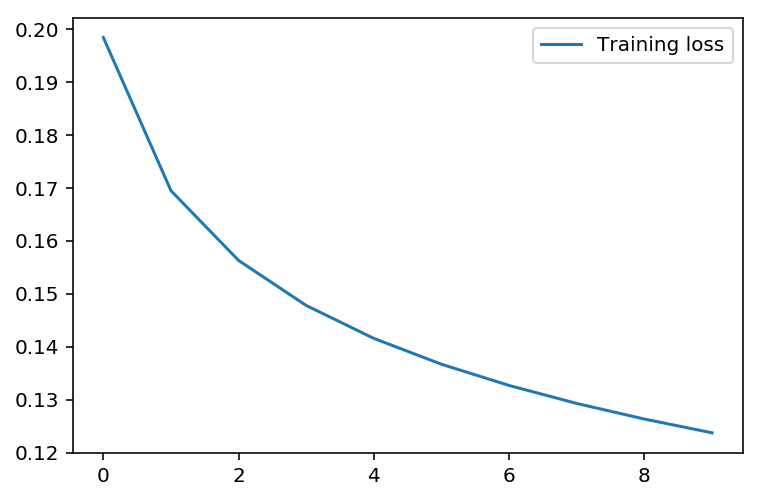

In [181]:
nnetLN.visualise_training()

In [187]:
nnetLN.predict("This product sucks!! I bought it and it proved disgusting. Do not buy this rip-off.")

array([ 0.13081071])

In [186]:
nnetLN.predict("Wonderful and very awesome quality product")

array([ 0.67737192])